In [26]:
import numpy as np
from numpy import linalg as la
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 10

We define two functions. One builds Gaussian states from $n$ and $r$ and the other builds Gaussian measurements from $n$.

They are obtained first by building the matrix of, respectively, the discrete annihilation and the discrete position operators, then by seeking their eigenvectors.

In [27]:
# Here, J_x is in fact 2*J_x and J_y is in fact 2*i*P_n= -2*i*J_y
def make_states(n,r) :
    vv=[]


    alpha=np.sqrt(1-np.exp(-4*r))
    a = n/2*(n/2 +1)

    J_x = np.zeros((n+1,n+1))
    J_y = np.zeros((n+1,n+1))
    
    # Values at the boundaries are defined :
    
    J_x[0,1]=np.sqrt(a+n/2*(-n/2+1))
    J_x[n,n-1]=np.sqrt(a-n/2*(n/2-1))
    J_y[0,1]= np.sqrt(a+n/2*(-n/2+1))
    J_y[n,n-1]=- np.sqrt(a-n/2*(n/2-1))
    
    # Other values within the matrices are defined :
    
    i=-n/2+1

    while i<=n/2-1 :
        if a-i*(i+1) >= 0 :
            high=np.sqrt(a-i*(i+1))
        if a-i*(i-1) >= 0 :
            low=np.sqrt(a-i*(i-1))
            
        J_x[i+n/2,i+n/2+1] = high
        J_x[i+n/2,i+n/2-1] = low
        J_y[i+n/2,i+n/2+1] =  high
        J_y[i+n/2,i+n/2-1] = - low
        i+=1
    
    # We write the operator which has eigenvalues x. We call it Anni, short for Annihilation despite it not being exactly the
    # annihilation operator :
    
    Anni=(alpha**(-1))*(J_x/(np.sqrt(n)) + np.exp(-2*r) *J_y/(np.sqrt(n)))/2
    
    # We take eigenvalues and eigenvectors :
    
    w, v = la.eig(Anni) 

    k=0
    while k<n+1 :
        vv.append(v[:,k])
        k+=1
        
    # np.eig puts elements of an eigenvector in columns.
    # The loop above builds the eigenvectors by putting elements of the same eigenvector in a row. 
    # This will be easier to manipulate.

    return w,vv 

# This function outputs the eigenvalues corresponding to the set of inputs 
# and the eigenvectors corresponding to the Gaussian states.

In [28]:
# Here, J_x is in fact 2*J_x.

# The principle behind the code below is exactly that of the one above.

def make_meas(n) :
    vv=[]
    a = n/2*(n/2 +1)

    J_x = np.zeros((n+1,n+1))
    J_x[0,1]=np.sqrt(a+n/2*(-n/2+1))
    J_x[n,n-1]=np.sqrt(a-n/2*(n/2-1))
    i=-n/2+1

    while i<=n/2-1 :
        if a-i*(i+1) >= 0 :
            high=np.sqrt(a-i*(i+1))
        if a-i*(i-1) >= 0 :
            low=np.sqrt(a-i*(i-1))
    
        J_x[i+n/2,i+n/2+1] = high
        J_x[i+n/2,i+n/2-1] = low
        i+=1
    
    X_n=J_x/(2*np.sqrt(n))
    s,t  = la.eig(X_n)
    k=0
    while k<n+1 :
        vv.append(t[:,k])
        k+=1

    return s,vv

# This function outputs the eigenvalues corresponding to the set of outputs 
# and the eigenvectors corresponding to the Gaussian measurements.
    

We select specific values for $q$, the number of qubits (which is the number of inputs and outputs minus $1$ : $q=n-1$) and for $r$, the positive squeezing parameter.

In [29]:
q=1
r=0.015

In [30]:
a=make_states(q, r)[1]

In [31]:
b=make_meas(q)[1]

We obtain the probabbilities associated to $x$ and $y$ by apply states $|{\Psi_x}>$ to measurements to obtain $P(x,y) = |<{\Psi_x}| y>|^{ 2} $.

We define a function which builds the probability matrix from states and measurements.


In [32]:
def make_prob_matrix(state,meas) :
    state_meas = abs(np.dot(state,meas))
    p=state_meas**2
    
    return p
    

In [33]:
p=make_prob_matrix(a,b)

In [34]:
print('Gaussian Probability Matrix :')
print()
print(p)

Gaussian Probability Matrix :

[[ 0.37933987  0.62066013]
 [ 0.62066013  0.37933987]]


We build a function we call 'verify' to check that is is indeed a 'probability matrix' (i.e. : that the elements of any line of the matrix sum to 1). 

This will not be needed in the future but is just set as a safety net.

In [35]:
def verify(p) :
    
    i=0
    indic=0
    while i<len(p) :
        s=np.sum(p[i])
        if not 0.999<s<1.001 :
            indic+=1  
        
        i+=1
    if indic==0 :
        print('verified')
    else :
        print('not a probability matrix')

In [36]:
verify([[1,2],[3,4]])

not a probability matrix


In [37]:
verify(p)

verified


We have reviewed all steps allowing us to define a function which builds the discrete version of $f$ from values of $q$ and $r$ and from two positive integers which are positions in the probability matrix (going from $0$ to $q$), corresponding to an input $x$ (line number) and an output $y$ (column number). The function  prints the values of $x$ and $y$ and returns the value of $f$ obtained from these.

In [38]:
def build_f(q,r,i,j) :
    
    c=make_states(q,r)[1] # builds states 
    d=make_meas(q)[1] # builds measurements
    
    p = make_prob_matrix(c,d) # builds a probability matrix from states and measurements

    x= make_states(q,r)[0][i] # gets input value from line number in probability matrix
    y=make_meas(q)[0][j] # gets output value from column number in probability matrix
    
    # The rest builds f :
    
    a = q/2*(q/2 +1)
    
    if i == 0 :
        f= np.sqrt(a-x*(x-1))*np.sqrt(p[i+1][j]/p[i][j])
    elif i+1==len(p) :
        f= np.sqrt(a-x*(x+1))*np.sqrt(p[i-1][j]/p[i][j])
    else :
        f=np.sqrt(a-x*(x+1))*np.sqrt(p[i-1][j]/p[i][j]) + np.sqrt(a-x*(x-1))*np.sqrt(p[i+1][j]/p[i][j])
    
    #print(p)    
    #print('x=',x)
    #print('y=',y)
    
    return f
    
    

## n=2 case

We treat the $n=2$ case by comparing the values of $<f>$ for the best injective strategy (BIS) and the best non-injective strategy (BNIS). The function below computes the mean value for $f$ for a given probability linked to the input $\frac{1}{2}$ : $P(x=\frac{1}{2})$ over a range of $r$ values.

In [39]:
def make_f_mean(P) :
    r=0.001
    listr=[] # r values
    one=[] # <f> for BIS 
    two=[] # <f> for BNIS 
    
    while r < 1 :
        listr.append(r)
        one.append(P*build_f(q,r,0,0) + (1-P)*build_f(q,r,1,1))
        
        # The conditional part below ensures that the best of the two non-injective startegies is selected depending on P
        if P<=0.5 :
            two.append(P*build_f(q,r,0,1) + (1-P)*build_f(q,r,1,1))
        else :
            two.append(P*build_f(q,r,0,0) + (1-P)*build_f(q,r,1,0))
        r=r+0.005
    
    return listr,one,two
    

In [40]:
p=0.7 # probability associated to the input 0.5

In [41]:
r_list=make_f_mean(p)[0]
bis=make_f_mean(p)[1]
bnis=make_f_mean(p)[2]

In [42]:
diff= np.array(bis) - np.array(bnis) # computes the difference between values of <f> for BIS and BNIS

In [43]:
n=100

We look at the $<f>$ difference between BIS and BNIS as a function of r for a choice of probabilities of inputs :

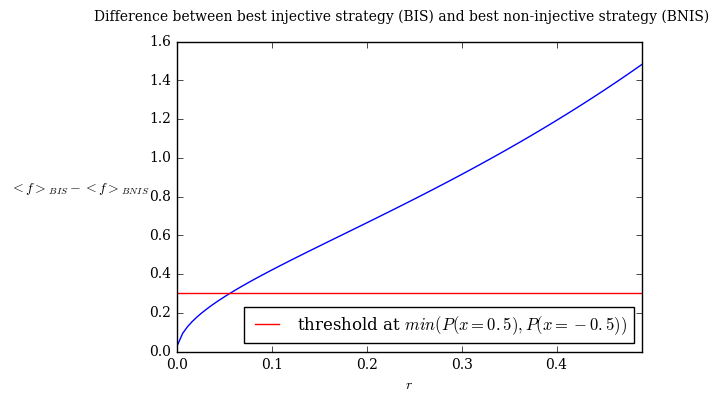

In [44]:
if p<=0.5 :
     pp=p
else :
     pp=1-p

plt.suptitle('Difference between best injective strategy (BIS) and best non-injective strategy (BNIS)')
plt.xlabel('$r$')
plt.ylabel('$<f>_{BIS} - <f>_{BNIS} $ ',rotation=0, fontsize=10, labelpad=50)
plt.xlim(0,0.49)
plt.plot(r_list[0:n],diff[0:n])
plt.plot(r_list[0:n+1],[pp]*(n+1), label='threshold at $min(P(x=0.5),P(x=-0.5))$', color='red')
plt.legend(loc='lower right')
plt.show()


We observe that BIS yields higher mean values for the function f than BNIS for all values of the squeezing parameter but we recall that, to compute $<f>-<H>$, we still have to remove the mean energy to the value $<f>$. In the non-injective case, we remove nothing because the mean energy is zero. In the injective case, the minimal value of mean energy is the lowest probability associated to either of the two inputs. This is why we highlighted that value as a threshold below which BIS does worse than BNIS. 

We know look at $<f>-<H>$ for all possible probabilities of inputs at various values of r.

In [45]:
def P_lists(r) :

    P_list=[] # list of probabilities for the input x=0.5
    one_P=[] # list of <f>-<H> values for BIS
    two_P=[] # list of <f>-<H> values for BNIS
    P=0
    while P <= 1 :
        P_list.append(P)
        # the conditional part below chooses the lowest probability associated to an input.
        if P<=0.5 :
            PP=P
        else :
            PP=1-P
            
        one_P.append(make_f_mean(P)[1][r]-PP)
        two_P.append(make_f_mean(P)[2][r])
        P+=0.1
    return P_list, one_P, two_P

Below the threshold, BNIS does better than BIS :

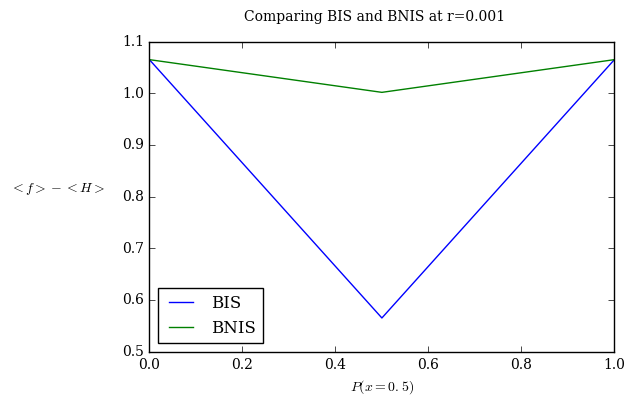

In [46]:
plt.suptitle('Comparing BIS and BNIS at r=0.001')
plt.xlabel('$P(x=0.5)$')
plt.ylabel('$<f> - <H>$ ', rotation=0, fontsize=10, labelpad=45)
plt.plot(P_lists(0)[0],P_lists(0)[1],  label='BIS')
plt.plot(P_lists(0)[0],P_lists(0)[2],  label='BNIS')
plt.legend(loc='lower left')
plt.show()

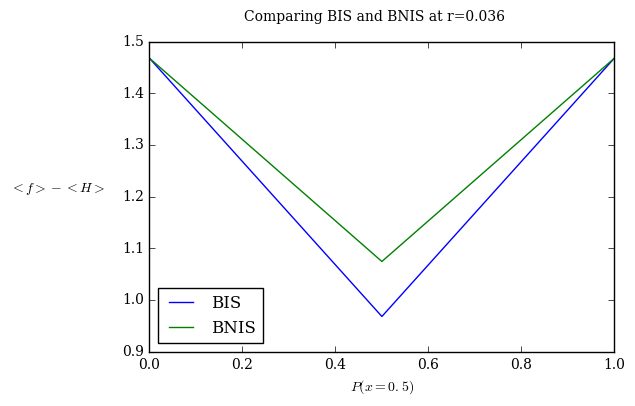

In [47]:
plt.suptitle('Comparing BIS and BNIS at r=0.036')
plt.xlabel('$P(x=0.5)$')
plt.ylabel('$<f> - <H>$ ', rotation=0, fontsize=10, labelpad=45)
plt.plot(P_lists(2)[0],P_lists(7)[1],  label='BIS')
plt.plot(P_lists(2)[0],P_lists(7)[2],  label='BNIS')
plt.legend(loc='lower left')
plt.show()


Above the threshold, BIS does better than BNIS :

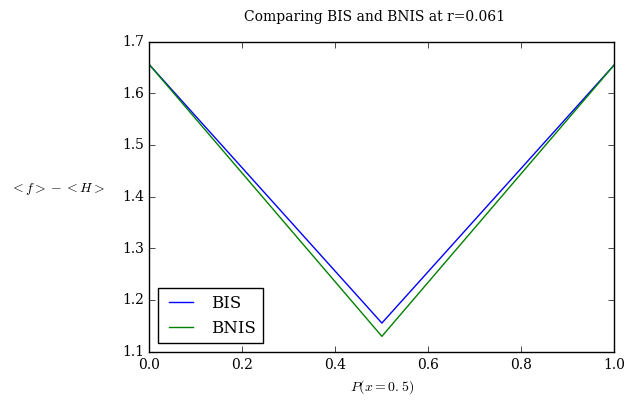

In [48]:
plt.suptitle('Comparing BIS and BNIS at r=0.061')
plt.xlabel('$P(x=0.5)$')
plt.ylabel('$<f> - <H>$ ', rotation=0, fontsize=10, labelpad=45)
plt.plot(P_lists(2)[0],P_lists(12)[1],  label='BIS')
plt.plot(P_lists(2)[0],P_lists(12)[2],  label='BNIS')
plt.legend(loc='lower left')
plt.show()


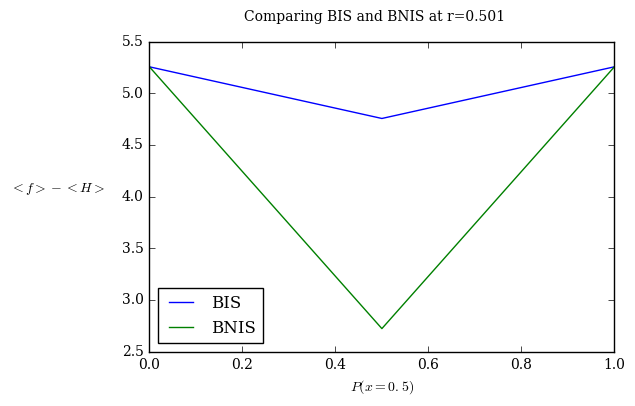

In [49]:
plt.suptitle('Comparing BIS and BNIS at r=0.501')
plt.xlabel('$P(x=0.5)$')
plt.ylabel('$<f> - <H>$ ', rotation=0, fontsize=10, labelpad=45)
plt.plot(P_lists(2)[0],P_lists(100)[1],  label='BIS')
plt.plot(P_lists(2)[0],P_lists(100)[2],  label='BNIS')
plt.legend(loc='lower left')
plt.show()

The mirror symmetry displayed in the diagrams above is a direct visualization of the invariance under a relabelling of the two inputs.